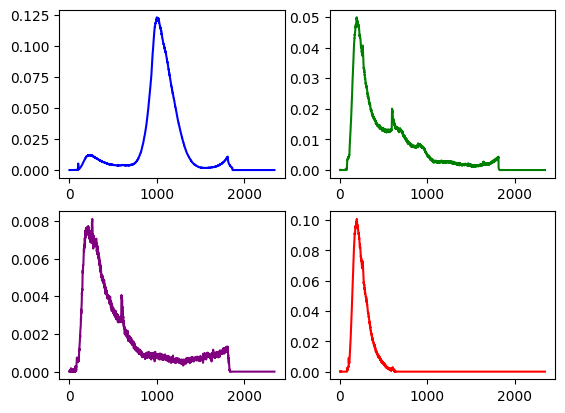

In [67]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pybeads
import os

# CSVファイルを読み込み、最終行を除去
file_path = '/workspaces/Modulus/DESK/Peak_analysis/SWNT.csv'
data = pd.read_csv(file_path, skipfooter=1, engine='python')

# Figureオブジェクトを作成
fig = plt.figure()
# Axesオブジェクトを作成
# 1つのFigureに複数のAxesを作成
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# プロットするデータ
x = data['Temp.']
H2 = data['H2']
CO = data['CO']
CO2 = data['CO2']
H2O = data['H2O']

# プロット
ax1.plot(x, H2, 'b')
ax2.plot(x, CO, 'g')
ax3.plot(x, CO2, 'purple')
ax4.plot(x, H2O, 'r')

# プロットの表示
plt.show()

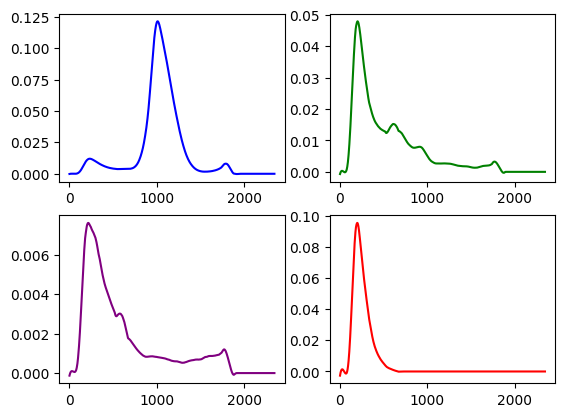

In [68]:
# H2, CO, CO2, H2Oシグナルを平滑化（Savitzky-Golayフィルタ使用）

smoothed_data = {
    'H2': savgol_filter(data['H2'], window_length=151, polyorder=3),
    'H2O': savgol_filter(data['H2O'], window_length=151, polyorder=3),
    'CO': savgol_filter(data['CO'], window_length=151, polyorder=3),
    'CO2': savgol_filter(data['CO2'], window_length=151, polyorder=3)
}
#Figureオブジェクトを作成
fig = plt.figure()
#Axesオブジェクトを作成
#1つのFigureに複数のAxesを作成
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
#プロットするデータ
x = data['Temp.']
H2 = smoothed_data['H2']
CO = smoothed_data['CO']
CO2 = smoothed_data['CO2']
H2O = smoothed_data['H2O']

#プロット
ax1.plot(x, H2, 'b')
ax2.plot(x, CO, 'g')
ax3.plot(x, CO2, 'purple')
ax4.plot(x, H2O, 'r')

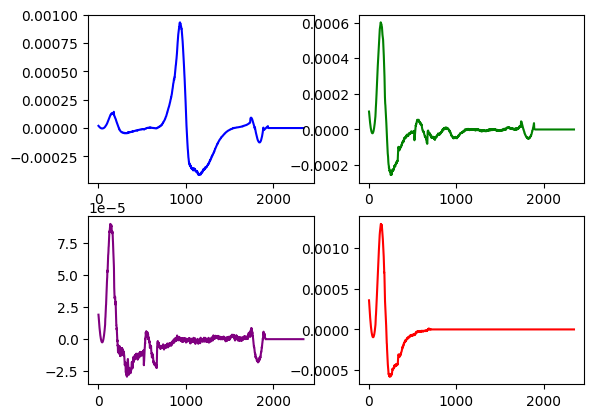

In [69]:
# 各ガスシグナルの微分を計算
derivatives = {
    'H2': np.gradient(smoothed_data['H2'], data['Temp.']),
    'H2O': np.gradient(smoothed_data['H2O'], data['Temp.']),
    'CO': np.gradient(smoothed_data['CO'], data['Temp.']),
    'CO2': np.gradient(smoothed_data['CO2'], data['Temp.'])
}

#Figureオブジェクトを作成
fig = plt.figure()
#Axesオブジェクトを作成
#1つのFigureに複数のAxesを作成
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
#プロットするデータ
x = data['Temp.']
H2 = derivatives['H2']
CO = derivatives['CO']
CO2 = derivatives['CO2']
H2O = derivatives['H2O']

#プロット
ax1.plot(x, H2, 'b')
ax2.plot(x, CO, 'g')
ax3.plot(x, CO2, 'purple')
ax4.plot(x, H2O, 'r')

# ゼロ交差点を格納する辞書
zero_crossing_indices = {}

# 各ガスについてループを回して、微分が0に近い箇所を探す
for gas in ['H2', 'H2O', 'CO', 'CO2']:
    zero_crossing_indices[gas] = np.where(np.abs(derivatives[gas]) < 0.6)[0]


In [75]:
# ピーク特性を格納する辞書を作成
peak_properties = {}

for gas in ['H2', 'CO', 'CO2', 'H2O']:
    signal = smoothed_data[gas]
    temperature = data['Temp.']

    # ゼロ交差点の中で最大のy値を持つインデックスを特定
    peak_index = np.argmax(signal[zero_crossing_indices[gas]])
    peak_temperature = zero_crossing_indices[gas][peak_index]
    peak_intensity = signal[peak_temperature]
    
    # 半値を計算し、FWHMの両端を探す
    half_max = peak_intensity / 2
    left_idx = np.where(signal[:peak_temperature] < half_max)[0]
    right_idx = np.where(signal[peak_temperature:] < half_max)[0]

    # FWHMに基づいた開始温度と終了温度の特定
    start_temp = temperature[left_idx[-1]] if left_idx.size > 0 else temperature[0]
    end_temp = temperature[peak_temperature + right_idx[0]] if right_idx.size > 0 else temperature[-1]

    # 対称性の計算
    symmetry = ((peak_temperature - start_temp) - (end_temp - peak_temperature))
    
    # 特性を辞書に格納
    peak_properties[gas] = {
        "Peak Temperature": peak_temperature,
        "Peak Intensity": peak_intensity,
        "FWHM": end_temp - start_temp,
        "Start Temperature": start_temp,
        "End Temperature": end_temp,
        "Symmetry": symmetry
    }

# 結果を表示
peak_properties_df = pd.DataFrame(peak_properties).T
print(peak_properties_df)
peak_properties_df.to_csv(f'{os.path.splitext(os.path.basename(file_path))[0]}peak_properties.csv')



     Peak Temperature  Peak Intensity   FWHM  Start Temperature  \
H2             1008.0        0.121312  270.0              915.0   
CO              201.0        0.047976  187.0              136.0   
CO2             215.0        0.007601  316.0              140.0   
H2O             198.0        0.095521  164.0              138.0   

     End Temperature  Symmetry  
H2            1185.0     -84.0  
CO             323.0     -57.0  
CO2            456.0    -166.0  
H2O            302.0     -44.0  
